# Amazon Sentiment Analysis

__Author : Nutan Mandale__
    
    
__Mentor: Vincent Ramadhine__

In this notebook I am doing a sentiment analysis on the amazon's books review. The steps that will be followed for the analysis are

1.Importing the data from JSON file and creating a dataframe.

2.Cleaning and analysing the data.

3.Analysing with BoW approach with the help of various classification models.

4.Doing the parameter tunning for best performing model to further improve the performance.

5.Analysing with term frequency and document frequeny on various models.

6.Doing parameter tunning for best performing model to improve performance.

7.Tunning the vectorizer with ngrams and min_df and analyzing with various models.

8.Conclusion

### Data Description:

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

The data I am dealing with is the Books review.
This is a JSON file with more than 22 million reviews.

Some important features in this data set are:
    
    reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
    asin - ID of the product, e.g. 0000013714
    reviewerName - name of the reviewer
    helpful - helpfulness rating of the review, e.g. 2/3
    reviewText - text of the review
    overall - rating of the product
    summary - summary of the review
    unixReviewTime - time of the review (unix time)
    reviewTime - time of the review (raw)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import naive_bayes
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer,accuracy_score,roc_curve,auc,classification_report
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import pydotplus
import graphviz

The data set contains more than 22 million reviews so will import the data in small sample.

### Data Extraction

In [2]:

reviews = []
MAX_REVIEWS = 100000
filename = "./Books_5.json"
with open(filename, 'r') as f:
    for i in range(MAX_REVIEWS):
        reviews.append(f.readline().strip()) 
df = pd.concat([pd.read_json(review, lines=True) for review in reviews], ignore_index=True) 
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,000100039X,"[0, 0]",5,Spiritually and mentally inspiring! A book tha...,"12 16, 2012",A10000012B7CGYKOMPQ4L,Adam,Wonderful!,1355616000
1,000100039X,"[0, 2]",5,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800
2,000100039X,"[0, 0]",5,This book provides a reflection that you can a...,"01 18, 2014",A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,1390003200
3,000100039X,"[0, 0]",5,I first read THE PROPHET in college back in th...,"09 27, 2011",A1MOSTXNIO5MPJ,Alan Krug,Timeless for every good and bad time in your l...,1317081600
4,000100039X,"[7, 9]",5,A timeless classic. It is a very demanding an...,"10 7, 2002",A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,1033948800


### Data Analysis

In [3]:
df.shape

(100000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
asin              100000 non-null object
helpful           100000 non-null object
overall           100000 non-null int64
reviewText        100000 non-null object
reviewTime        100000 non-null object
reviewerID        100000 non-null object
reviewerName      99948 non-null object
summary           100000 non-null object
unixReviewTime    100000 non-null int64
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [5]:
# Drop missing values
df.dropna(inplace=True)

In [6]:
df.shape

(99948, 9)

In [7]:
# Drop missing values
df.dropna()

# Remove any 'neutral' ratings equal to 3
df = df[df['overall'] != 3]

# Encode 4s and 5s as 1 (rated positively)
# Encode 1s and 2s as 0 (rated poorly)
df['Positively Rated'] = np.where(df['overall'] > 3, 1, 0)

df.shape

(88998, 10)

In [8]:
df.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Positively Rated
0,000100039X,"[0, 0]",5,Spiritually and mentally inspiring! A book tha...,"12 16, 2012",A10000012B7CGYKOMPQ4L,Adam,Wonderful!,1355616000,1
1,000100039X,"[0, 2]",5,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800,1
2,000100039X,"[0, 0]",5,This book provides a reflection that you can a...,"01 18, 2014",A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,1390003200,1


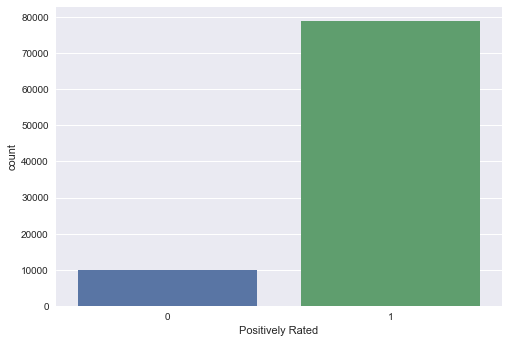

In [9]:
sns.countplot("Positively Rated",data=df);

From the plot we can see we have more postively Rated reviews than that of negatively rated reviews.

In [10]:
# Most ratings are positive
df['Positively Rated'].mean()

0.8870648778624238

The data is imbalanced data where we have more than 86% of positively rated reviews.

Let us seperate our dependent and independant variables.

In [11]:
X = df.reviewText
y = df['Positively Rated']
print("Total number of reviews: ",X.shape)
print("Total number of positive reviews: ",y.shape)

Total number of reviews:  (88998,)
Total number of positive reviews:  (88998,)


In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.3,
                                                    random_state=50)

In [13]:
X_train.shape

(62298,)

In [14]:
X_train.head()

50035    this one is for the granddaughter.  If she can...
46895    This is one of the best fictions I have read i...
14160    Finally The Lord Of The Rings has been combine...
88820    I first read this book after I borrowed it fro...
97403    It is an insanely funny, yet touching work.  J...
Name: reviewText, dtype: object

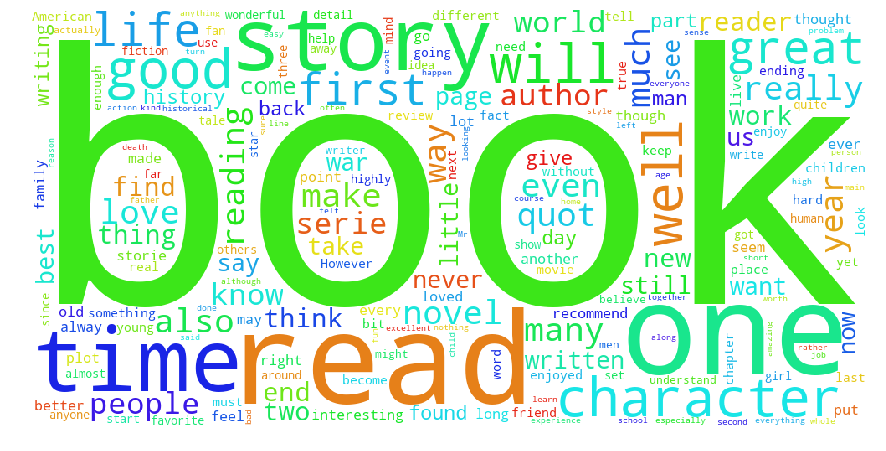

In [15]:
from wordcloud import WordCloud
text = " ".join(X_train.ravel())
wordcloud = WordCloud(width = 1000, height = 500,background_color='white').generate(text)
plt.figure(figsize=(15,8))
plt.axis("off")
plt.imshow(wordcloud);

As seen from the word cloud 'book' is the most frequently used word, as we are doing sentiment analysis of books reviews. Other than books we see 'read','character','novel' and 'story'these words used .

### Bag of words(BoW)

Initially we will approach the text with bag of words approach .We will use count vectorizer which convert a collection of text documents to a matrix of token counts

Let us begin with removing stop words from the document.

In [16]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer(stop_words = 'english').fit(X_train)

In [17]:
vect.get_feature_names()[::2000]

['00',
 '8100m',
 'agendas',
 'anthropologically',
 'aufzublasen',
 'behaviorist',
 'bookchin',
 'butual',
 'chantry',
 'cocoons',
 'continuous',
 'curses',
 'derides',
 'distinctions',
 'edification',
 'erdich',
 'faludi',
 'foleysince',
 'gavan',
 'greenville',
 'heaters',
 'hren',
 'indonesians',
 'islamophobic',
 'khatuna',
 'lehman',
 'lutnik',
 'mccourtis',
 'mixer',
 'nation',
 'obey',
 'overpraised',
 'peri',
 'pond',
 'prospective',
 'readaloud',
 'republicrats',
 'ruane',
 'seabiscuit',
 'sidelined',
 'sooth',
 'stoical',
 'swepted',
 'theres',
 'transport',
 'undisputable',
 'verdicts',
 'westmacott',
 'yaobang']

In [18]:
len(vect.get_feature_names())

96738

Let us see the different words and their frequency in the data set

In [19]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized.shape

(62298, 96738)

Let us fit the vectorized data into models.Here we will use Logistic regression, Random forest classifier,decision tree,Bernoulli naive bayes ,KNN and SVM classifiers.
We will do 10 fold cross validation and evaluate the models on their F1 score,area under curve and its accuracy.

As seen before the data is imbalanced so only accuracy is not the reliable method of evaluation for the model.

In [20]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))

# Results dataframe
columns = ['Model', 'Approach', 'F1 Score mean', 'AUC', 'Accuracy']
results = pd.DataFrame(columns=columns)

# evaluate each model in turn
names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_train_vectorized, y = y_train, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_train_vectorized, y = y_train, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_train_vectorized, y = y_train, cv=10, scoring='f1')
    
    names.append(name)
    row = [name, 'BoW Training', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" 
          %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
results.head()

ROC AUC: 0.87 (+/- 0.00) | Accuracy: 0.90 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.64 (+/- 0.03) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.70 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.82 (+/- 0.01) | Accuracy: 0.85 (+/- 0.00) | f1 Score: 0.92 (+/- 0.00) [BNB]
ROC AUC: 0.67 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.88 (+/- 0.01) | Accuracy: 0.92 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [SVM]


,Model,Approach,F1 Score mean,AUC,Accuracy
0,LR,BoW Training,0.944630,0.872918,0.896193
1,RFC,BoW Training,0.940447,0.643184,0.887589
2,DST,BoW Training,0.943054,0.699132,0.894796
3,BNB,BoW Training,0.916936,0.820239,0.852323
4,KNN,BoW Training,0.940547,0.669898,0.887813


In [21]:
X_test_vectorized = vect.transform(X_test)

In [22]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))
# evaluate each model in turn

names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_test_vectorized, y = y_test, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_test_vectorized, y = y_test, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_test_vectorized, y = y_test, cv=10, scoring='f1')
    
    names.append(name)
    
    row = [name, 'BoW Test', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
    
results    

ROC AUC: 0.82 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.60 (+/- 0.03) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.68 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.72 (+/- 0.02) | Accuracy: 0.86 (+/- 0.01) | f1 Score: 0.93 (+/- 0.00) [BNB]
ROC AUC: 0.67 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.86 (+/- 0.01) | Accuracy: 0.91 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [SVM]


,Model,Approach,F1 Score mean,AUC,Accuracy
0,LR,BoW Training,0.944630,0.872918,0.896193
1,RFC,BoW Training,0.940447,0.643184,0.887589
2,DST,BoW Training,0.943054,0.699132,0.894796
3,BNB,BoW Training,0.916936,0.820239,0.852323
4,KNN,BoW Training,0.940547,0.669898,0.887813
5,SVM,BoW Training,0.952968,0.883666,0.916321
6,LR,BoW Test,0.941578,0.816990,0.890150
7,RFC,BoW Test,0.939466,0.603759,0.885843
8,DST,BoW Test,0.940418,0.680579,0.889812
9,BNB,BoW Test,0.925883,0.723836,0.864644


### Tunning parameters

SVM is performing best on train as well as test data set. Let us do some parameter tunning. In parameter tunning I will be using different values of C to get maximum area under score and f1 score.

In [23]:
X_test_vectorized = vect.transform(X_test)
model = LinearSVC(C = 0.1)
model.fit(X_train_vectorized,y_train)
y = model.predict(X_test_vectorized)
y_score = model.decision_function(X_test_vectorized)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))
print('cr:', classification_report(y_test,y))
print(y)

AUC for Single Linear SVC
 0.912584065627
cr:              precision    recall  f1-score   support

          0       0.73      0.61      0.66      3048
          1       0.95      0.97      0.96     23652

avg / total       0.92      0.93      0.93     26700

[1 1 1 ..., 0 1 1]


In [24]:
X_test_vectorized = vect.transform(X_test)
model = LinearSVC(C = 0.5)
model.fit(X_train_vectorized,y_train)
y = model.predict(X_test_vectorized)
y_score = model.decision_function(X_test_vectorized)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))
print('cr:', classification_report(y_test,y))

AUC for Single Linear SVC
 0.894772914056
cr:              precision    recall  f1-score   support

          0       0.67      0.62      0.64      3048
          1       0.95      0.96      0.96     23652

avg / total       0.92      0.92      0.92     26700



In [25]:
C_range=list(range(1,20))
auc_score=[]
for c in C_range:
    model = LinearSVC(C = c)
    scores = cross_val_score(model, X = X_test_vectorized, y = y_test, cv=10, scoring='roc_auc')
    auc_score.append(scores.mean())
print(auc_score)

[0.86449079002890239, 0.85716177726054121, 0.85319790536167339, 0.85077252058609554, 0.84908484320685162, 0.84782748525427665, 0.8468636270113159, 0.84605462334876336, 0.84533798465869714, 0.84475697196706656, 0.84428831864968257, 0.84390400513867014, 0.84358428611832326, 0.84328682385811893, 0.84299626987892007, 0.84278738474061876, 0.8424842981032945, 0.84230231378970777, 0.84213590847429054]


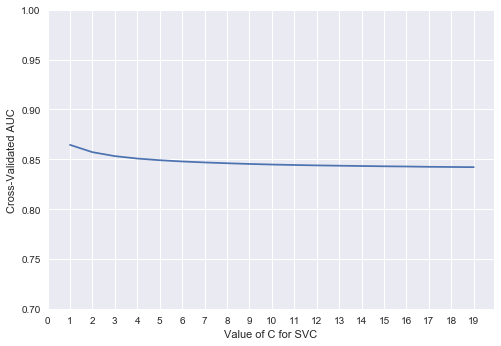

In [26]:
C =list(range(1,20))
plt.plot(C,auc_score)
plt.xticks(np.arange(0,20,1))
plt.yticks(np.arange(0.7,1,0.05))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated AUC');

In [27]:
C_range=list(range(1,20))
f1score=[]
for c in C_range:
    model = LinearSVC(C = c)
    f1_scores = cross_val_score(estimator = model, X = X_test_vectorized, y = y_test, cv=10, scoring='f1')
    f1score.append(f1_scores.mean())
print(f1score)

[0.94862572810897983, 0.9462504997100647, 0.94484479350745754, 0.94378924389275798, 0.94308343453408594, 0.94246501828305251, 0.94160043360907564, 0.94140353051393633, 0.94125675420189625, 0.94093666483609639, 0.94072423661630966, 0.94057196046742997, 0.94033548558422331, 0.9402506244715001, 0.9400053214341334, 0.94006750312573395, 0.93994269782420314, 0.93958990960632538, 0.93932802956121964]


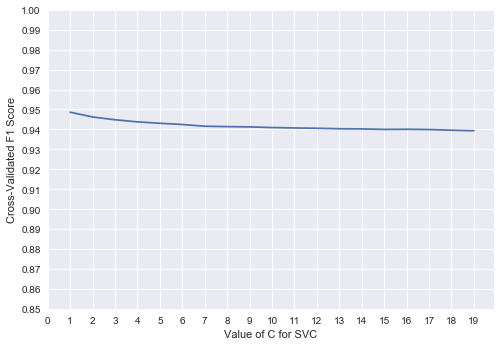

In [28]:
C =list(range(1,20))
plt.plot(C,f1score)
plt.xticks(np.arange(0,20,1))
plt.yticks(np.arange(0.85,1,0.01))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated F1 Score');

### Tfidf

Let us go by term frequency and document frequency to analyze the sentiments in the data.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect_t = TfidfVectorizer(min_df=10).fit(X_train)
len(vect_t.get_feature_names())


22288

In [30]:
X_train_vectorized_t = vect_t.transform(X_train)
X_train_vectorized_t.shape

(62298, 22288)

In [31]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))

# Results dataframe
#columns = ['Model', 'Approach', 'F1 Score mean', 'F1 Score std', 'AUC', 'Accuracy']
#results = pd.DataFrame(columns=columns)

# evaluate each model in turn
names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_train_vectorized_t, y = y_train, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_train_vectorized_t, y = y_train, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_train_vectorized_t, y = y_train, cv=10, scoring='f1')
    
    names.append(name)
    row = [name, 'Tfidf Training', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" 
          %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
results.shape

ROC AUC: 0.69 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.74 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.72 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.80 (+/- 0.01) | Accuracy: 0.81 (+/- 0.01) | f1 Score: 0.89 (+/- 0.00) [BNB]
ROC AUC: 0.81 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.95 (+/- 0.00) | Accuracy: 0.94 (+/- 0.00) | f1 Score: 0.97 (+/- 0.00) [SVM]


(18, 5)

In [32]:
X_test_vectorized_t = vect_t.transform(X_test)

In [33]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))
# evaluate each model in turn

names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_test_vectorized_t, y = y_test, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_test_vectorized_t, y = y_test, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_test_vectorized_t, y = y_test, cv=10, scoring='f1')
    
    names.append(name)
    
    row = [name, 'Tfidf Test', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
    
results.shape    

ROC AUC: 0.55 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.73 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.69 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.77 (+/- 0.02) | Accuracy: 0.80 (+/- 0.01) | f1 Score: 0.88 (+/- 0.01) [BNB]
ROC AUC: 0.82 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.94 (+/- 0.01) | Accuracy: 0.93 (+/- 0.00) | f1 Score: 0.96 (+/- 0.00) [SVM]


(24, 5)

In this case we see SVM is giving us better score than that of other models.

### Tunning the vectorizer

In [34]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=10, ngram_range=(1,2)).fit(X_train)

X_train_vectorized_1 = vect.transform(X_train)

len(vect.get_feature_names())

118254

In [35]:
X_train_vectorized_1.shape

(62298, 118254)

Let us train the model on training data

In [36]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))

# Results dataframe
#columns = ['Model', 'Approach', 'F1 Score mean', 'F1 Score std', 'AUC', 'Accuracy']
#results = pd.DataFrame(columns=columns)

# evaluate each model in turn
names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_train_vectorized_1, y = y_train, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_train_vectorized_1, y = y_train, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_train_vectorized_1, y = y_train, cv=10, scoring='f1')
    
    names.append(name)
    row = [name, 'Tunning Training', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" 
          %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
results.shape

ROC AUC: 0.91 (+/- 0.00) | Accuracy: 0.91 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [LR]
ROC AUC: 0.69 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.73 (+/- 0.01) | Accuracy: 0.90 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.80 (+/- 0.01) | Accuracy: 0.83 (+/- 0.01) | f1 Score: 0.90 (+/- 0.00) [BNB]
ROC AUC: 0.69 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.94 (+/- 0.01) | Accuracy: 0.94 (+/- 0.00) | f1 Score: 0.97 (+/- 0.00) [SVM]


(30, 5)

Testing the tuned mode on test data

In [37]:
vect = CountVectorizer(min_df=10, ngram_range=(1,2)).fit(X_test)

X_test_vectorized_1 = vect.transform(X_test)

len(vect.get_feature_names())

58698

In [38]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))
# evaluate each model in turn

names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_test_vectorized_1, y = y_test, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_test_vectorized_1, y = y_test, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_test_vectorized_1, y = y_test, cv=10, scoring='f1')
    
    names.append(name)
    
    row = [name, 'Tunning Test', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
    
results.shape

ROC AUC: 0.86 (+/- 0.01) | Accuracy: 0.90 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [LR]
ROC AUC: 0.71 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.69 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.76 (+/- 0.02) | Accuracy: 0.81 (+/- 0.01) | f1 Score: 0.89 (+/- 0.01) [BNB]
ROC AUC: 0.68 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.92 (+/- 0.01) | Accuracy: 0.93 (+/- 0.00) | f1 Score: 0.96 (+/- 0.00) [SVM]


(36, 5)

Tunning the vectorizer further more...
In the data analysis we see the word book occuring maximum.The word seems to be neutral in the context of sentiment analysis.Let us try to reduce the noise in our model by removing the word book 

In [39]:
# Fit the CountVectorizer to the training data
from sklearn.feature_extraction import text 

my_stop_words = ['book']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)
vect2 = CountVectorizer(stop_words = stop_words).fit(X_train)

In [40]:
vect2.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [41]:
X_train_vectorized_2 = vect2.transform(X_train)
X_train_vectorized_2.shape

(62298, 96737)

In [42]:
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))

# Results dataframe
#columns = ['Model', 'Approach', 'F1 Score mean', 'F1 Score std', 'AUC', 'Accuracy']
#results = pd.DataFrame(columns=columns)

# evaluate each model in turn
names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_train_vectorized_2, y = y_train, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_train_vectorized_2, y = y_train, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_train_vectorized_2, y = y_train, cv=10, scoring='f1')
    
    names.append(name)
    row = [name, 'Tunning2 Training', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" 
          %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
results.shape

ROC AUC: 0.87 (+/- 0.00) | Accuracy: 0.90 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.62 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.70 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.82 (+/- 0.01) | Accuracy: 0.85 (+/- 0.00) | f1 Score: 0.92 (+/- 0.00) [BNB]
ROC AUC: 0.68 (+/- 0.01) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.88 (+/- 0.01) | Accuracy: 0.92 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [SVM]


(42, 5)

In [43]:
vect = CountVectorizer(min_df=10, ngram_range=(1,2)).fit(X_test)

X_test_vectorized_2 = vect2.transform(X_test)

len(vect2.get_feature_names())

96737

In [44]:
#Fit into the model
models = []
models.append(('LR', LogisticRegression(penalty='l2', C=0.001)))
models.append(('RFC', ensemble.RandomForestClassifier(n_estimators=25,max_features=8, max_depth=20)))
models.append(('DST', DecisionTreeClassifier(max_depth=10, criterion='entropy')))
models.append(('BNB',BernoulliNB()))
models.append(('KNN',KNeighborsClassifier(n_neighbors=25)))
models.append(('SVM', LinearSVC()))
# evaluate each model in turn

names = []
for name, model in models:
    #predictions = model.predict(vect.transform(X_test))
    a_scores = cross_val_score(estimator = model, X = X_test_vectorized_2, y = y_test, cv=10, scoring='accuracy')
    scores = cross_val_score(estimator = model, X = X_test_vectorized_2, y = y_test, cv=10, scoring='roc_auc')
    f1_scores = cross_val_score(estimator = model, X = X_test_vectorized_2, y = y_test, cv=10, scoring='f1')
    
    names.append(name)
    
    row = [name, 'Tunning2 Test', f1_scores.mean(), scores.mean(), a_scores.mean() ]
    results.loc[len(results)] = row
    
    print("ROC AUC: %0.2f (+/- %0.2f) | Accuracy: %0.2f (+/- %0.2f) | f1 Score: %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), a_scores.mean(), a_scores.std(), f1_scores.mean(), f1_scores.std(), name))
    
results.shape

ROC AUC: 0.82 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [LR]
ROC AUC: 0.61 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [RFC]
ROC AUC: 0.68 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [DST]
ROC AUC: 0.72 (+/- 0.02) | Accuracy: 0.86 (+/- 0.01) | f1 Score: 0.93 (+/- 0.00) [BNB]
ROC AUC: 0.68 (+/- 0.02) | Accuracy: 0.89 (+/- 0.00) | f1 Score: 0.94 (+/- 0.00) [KNN]
ROC AUC: 0.86 (+/- 0.01) | Accuracy: 0.91 (+/- 0.00) | f1 Score: 0.95 (+/- 0.00) [SVM]


(48, 5)

Let us see the results of all the experiments above.

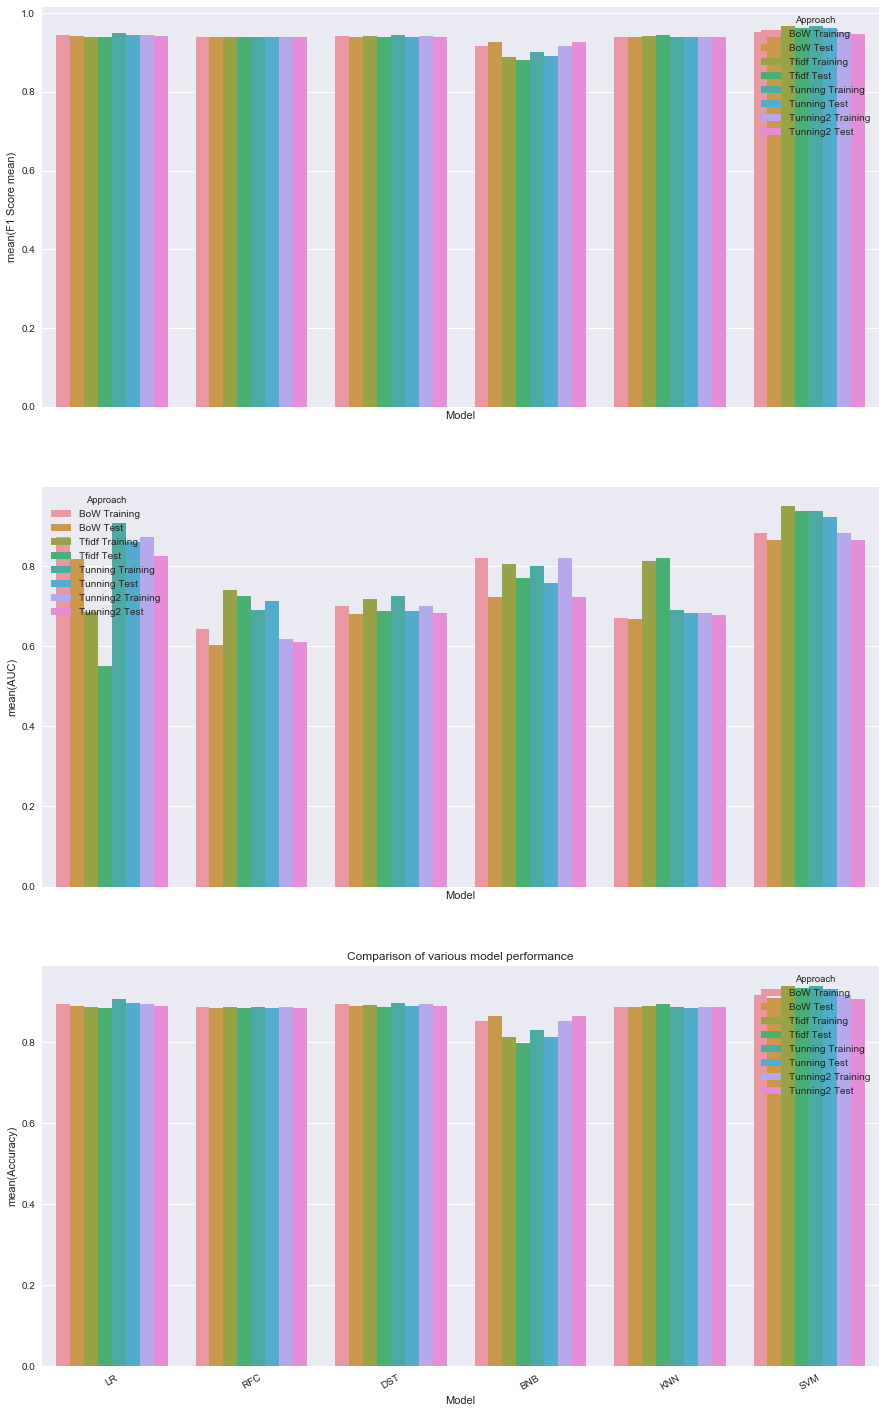

In [45]:
f,(ax1, ax2,ax3) = plt.subplots(3,1,figsize = (15,30), sharex = True)
sns.axes_style()
plt.title("Comparison of various model performance")
plt.xticks(rotation=30)
g = sns.barplot(x = "Model", y= "F1 Score mean", hue="Approach", data=results , ax = ax1)
g = sns.barplot(x = "Model", y= "AUC", hue="Approach", data=results, ax = ax2)
g = sns.barplot(x = "Model", y= "Accuracy", hue="Approach", data=results , ax = ax3);

## Conclusion

We have taken 100000 samples from over 22 million reviews of books.During the data analysis we realised the data to be unbalanced. More than 88% of the showed positive reviews. Considering accuracy as an evaluation metrics wont give us correct results.So area under curve and F1 score were used to evaluate different models.

In order to do the sentiment analysis I used Bag of Words approach and Tfidf (term frequency and document frequency approach).

I used following models to analyse the sentiments from the books review:
    
    1.Logistic Regression,
    2.Random forest clasifier,
    3.Decision tree Classifier,
    4.Bernoulli Naive Bayes.
    5.K Nearest Neighbour,
    6.SVM.
    
In the Bag of words approach it is found that SVM performs better than other 5 models.After tunning the parameters it is found that with the value of C= 0.1 SVM gave best results.
    
After doing Tfidf approach some tunning of vectorizer is also done by adding the n_gram range (1,2).Also by removing the words that are not used more than 10 time in the reviews.
    
In data analysis the word books have maximum frequency. Considering it as neutral(neither positive nor negative) word tried to tune the model by removing word 'books' from the data.
    
The results seems interesting.
    
The Tfidf approach performed well with SVM model amongst all. We got f1 score to be 96%, AUC to be 94% and accuracy to be 93%

### Referances

http://www.nltk.org/
    
    
https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781784390150/11/ch11lvl1sec71/creating-a-wordcloud
